##### 导入库

In [69]:
import pandas as pd
import numpy as np

from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import tree
from collections import Counter
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SVMSMOTE,SMOTE
from joblib import dump,load
from sklearn.model_selection import GridSearchCV

##### 选择数据

In [70]:
n='N_all.csv'
p='P_all.csv'
p='P_ice.csv'
p='P_her.csv'
p='P_mix.csv'
# p='P_ice1.csv'
way="mix"


##### 读取数据

In [71]:
fea_dict={
    'all':[
  "minvalue",
  "retang",
  "fft_abs_22",
  "fft_real_2",
  "lumpiness",
  "fft_real_5",
  "fft_angle_3",
  "alt_stderr_min_50",
  "fft_imag_6",
  "erbc_num10_focus2",
  "fft_imag_3",
  "alt_rvalue_min_50"
],


 'ice':[
  "retang",
  "erbc_num10_focus4",
  "fft_abs_22",
  "fft_real_2",
  "minindex",
  "alt_rvalue_min_50",
  "F2",
  "fft_imag_6",
  "asoc",
],

 'her':[
"fft_real_2",
"fft_real_5",
"dmq",
"fft_angle_3",
"erbc_num10_focus2",
"fft_imag_3",
"alt_rvalue_min_50"
],

'mix':[
"minvalue",
"cv",
"lumpiness",
"alt_rvalue_min_50",
"fft_angle_3",
"alt_stderr_min_50",
"maxindex"
]
}

fea_list=fea_dict[way]

def read_data(tit):
    path = 'E:\\desktop\\data\\app\\fea\\'
    #读取数据
    data = pd.read_csv(path+tit,encoding='gbk')
    data = data.set_index('name')
    return data

n_fea=read_data(n)
p_fea=read_data(p)

n_fea["tag"]=[0 for i in range(len(n_fea))]
p_fea["tag"]=[1 for i in range(len(p_fea))]

print(len(n_fea),len(p_fea))


523 75


##### 过采样

In [72]:
#过采样
over=SMOTE(random_state=0)
# over=SVMSMOTE(random_state=0)
np_fea=shuffle(pd.concat([n_fea,p_fea],axis=0))
x_data_=np_fea[fea_list]
y_data_=np_fea["tag"]

x_data,y_data=over.fit_resample(x_data_,y_data_)

#切分
x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,test_size=0.3)
print(x_data.shape)

(1046, 7)


In [73]:
def jugde(y_pred,y_true):
    tn,fn,tp,fp=0,0,0,0
    for i in range(len(y_pred)):
        
        if y_pred[i]==y_true[i]:
            if y_true[i]:
                tp+=1
            else:
                tn+=1
        else:
            if y_true[i]:
                fp+=1
            else:
                fn+=1

    print("检出率： ",tp,"/",tp+fp,' ',round(tp*100/(tp+fp),2),"%")
    print("误判率： ",fn,"/",tn+fn,' ',round(fn*100/(tn+fn),2),"%")
    print("精确率： ",(tn+tp),"/",(tn+fp+tp+fp),' ',round((tn+tp)*100/(tn+fp+tp+fp),2),"%")


##### 十折交叉验证

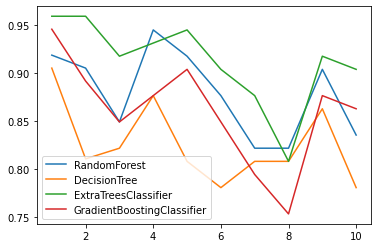

In [74]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

rfc = RandomForestClassifier()#n_estimators=25
rfc_s = cross_val_score(rfc,x_train,y_train,cv=10)

clf =DecisionTreeClassifier()
clf_s = cross_val_score(clf,x_train,y_train,cv=10)

ext = ExtraTreesClassifier()
ext_s = cross_val_score(ext,x_train,y_train,cv=10)



gbdt = GradientBoostingClassifier()
gbdt_s = cross_val_score(gbdt,x_train,y_train,cv=10)

plt.plot(range(1,11),rfc_s,label="RandomForest")
plt.plot(range(1,11),clf_s,label="DecisionTree")
plt.plot(range(1,11),ext_s,label="ExtraTreesClassifier")
plt.plot(range(1,11),gbdt_s,label="GradientBoostingClassifier")
plt.legend()
plt.show()


In [75]:
scorel =[]
for i in range(0,800,20):
    rfc = RandomForestClassifier(n_estimators=i+1,n_jobs=-1,random_state=0)
    score = cross_val_score(rfc,x_train,y_train,cv=10).mean()
    scorel.append(score)
n_estimators=scorel.index(max(scorel))*10+1
print(max(scorel),'使分数最高的n_estimators值为：',scorel.index(max(scorel))*10+1)
plt.figure()
plt.plot(range(1,801,20),scorel)
plt.show()


KeyboardInterrupt: 

#### 调整max_depth

In [ ]:

param_grid = {'max_depth':np.arange(1,20,1)}# 字典这里也可以输入多个参数

rfc = RandomForestClassifier(n_estimators=n_estimators,random_state=0)# 这里使用上面得到的最佳n_estimators值

GS = GridSearchCV(rfc,param_grid,cv=10)# cv为交叉验证的个数
GS.fit(x_train,y_train)

max_depth=GS.best_params_['max_depth']
print(GS.best_params_)
print(GS.best_score_)

{'max_depth': 8}
0.8251758607922991



#### 调整max_features

In [ ]:
#,'max_features' : np.arange(5,30,1),'min_samples_leaf' : np.arange(1,1+10,1),'min_samples_split' : np.arange(2,2+20,1),'min_samples_split' : np.arange(2,2+20,1)
param_grid = {'max_features' : np.arange(5,30,1)}
rf = RandomForestClassifier(n_estimators=n_estimators,random_state=0,max_depth=max_depth)

GS = GridSearchCV(rfc,param_grid,cv=10)# cv为交叉验证的个数
GS.fit(x_train,y_train)

max_features=GS.best_params_['max_features']
print(GS.best_params_)
print(GS.best_score_)

d:\anaconada\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
170 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
170 fits failed with the following error:
Traceback (most recent call last):
  File "d:\anaconada\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\anaconada\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "d:\anaconada\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "d:\anaconada\lib\site-packages\joblib\parallel.py", line 864, in dispatch_one_batch
    se

{'max_features': 11}
0.8278600518326545


In [ ]:
# #,'max_features' : np.arange(5,30,1),'min_samples_leaf' : np.arange(1,1+10,1),'min_samples_split' : np.arange(2,2+20,1),'min_samples_split' : np.arange(2,2+20,1)
# param_grid = {'max_features' : np.arange(5,30,1)}
# rf = RandomForestClassifier(n_estimators=341,random_state=0,max_depth=17)

# GS = GridSearchCV(rfc,param_grid,cv=10)# cv为交叉验证的个数
# GS.fit(x_train,y_train)

# print(GS.best_params_)
# print(GS.best_score_)

In [ ]:

###网格搜索寻参
parameters = {'splitter':('best','random')
              ,'criterion':("gini","entropy")
              ,"max_depth":[*range(1,15)]
              ,'min_samples_leaf':[*range(1,50,5)]
              ,'min_impurity_decrease':np.arange(0,0.05,0.00101)
}
#参数范围（字典类型） 
clf = tree.DecisionTreeClassifier(criterion='gini',  #划分标准gini指数
                                  random_state=25)   #随机种子
GS = GridSearchCV(clf,              #模型
                  parameters,       #参数字典
                  n_jobs=1,         #使用一个cpu
                  verbose=0,    #不打印中间过程
                  cv=10) #          #10折cv交叉验证 
GS.fit(x_train,y_train)# 在训练集上进行网格搜索
# GS.cv_results_    #打印模型搜索结果
# sorted(GS.cv_results_.keys())  #打印模型搜索结果的关键词
GS.best_params_,GS.best_score_,GS.score(x_train,y_train) #打印模型的最佳参数，最佳得分以及测试集的得分

KeyboardInterrupt: 

In [ ]:
# print(GS.best_params_)
# #保存模型
# dump(rfc,'rfc_'+way+".joblib")
# print("保存成功")